In [99]:
!pip install transformers torchaudio torchcodec

In [100]:
#from google.colab import drive
#drive.mount('/content/drive')

# Copie instantanée (une fois l'upload fini)
#!cp "/content/drive/MyDrive/dataset_pena.zip" "/content/dataset.zip"
#!unzip -q "/content/dataset.zip" -d "/content"

In [101]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
from IPython.display import Audio, display

CONFIG = {
    "sample_rate": 32000,
    "duration": 2.0,
    "n_mels": 64,
    "hidden_size": 1024,
    "num_layers": 3,
    "text_emb_dim": 768,
    "batch_size": 64,
    "learning_rate": 1e-4,
    "epochs": 100,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "dataset_path": "/content/dataset_pena",
    "csv_name": "metadata.csv",
    "save_dir": "/content/drive/MyDrive/Pena_Project"
}

os.makedirs(CONFIG['save_dir'], exist_ok=True)

In [102]:
import os
import pandas as pd

data = []

files = sorted(os.listdir(CONFIG['dataset_path']))
for filename in files:
    if filename.endswith(".wav"):
        audio_filename = filename

        text_filename = filename.replace(".wav", ".txt")
        text_path = os.path.join(CONFIG['dataset_path'], text_filename)

        if os.path.exists(text_path):
            with open(text_path, "r", encoding="utf-8") as f:
                prompt_text = f.read().strip()

            data.append([audio_filename, prompt_text])
        else:
            print(f"no text file for {audio_filename}")

if len(data) > 0:
    df = pd.DataFrame(data, columns=["file_name", "prompt"])
    csv_path = os.path.join(CONFIG['dataset_path'], "metadata.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved metadata to {csv_path}")
    print("5 first line:")
    print(df.head())
else:
    print("error nothing is valid")

Saved metadata to /content/dataset_pena/metadata.csv
5 first line:
      file_name                                             prompt
0   slice_1.wav  Music Musical instrument Orchestra Brass instr...
1  slice_10.wav  Music Musical instrument Orchestra Brass instr...
2  slice_11.wav  Music Musical instrument Orchestra Brass instr...
3  slice_12.wav  Music Musical instrument Orchestra Brass instr...
4  slice_13.wav  Music Musical instrument Orchestra Brass instr...


In [103]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class GreenTextToAudioLSTM(nn.Module):
    def __init__(self, audio_dim, text_emb_dim, hidden_size, num_layers):
        super().__init__()

        self.bert = AutoModel.from_pretrained("distilbert-base-uncased")
        for param in self.bert.parameters():
            param.requires_grad = False

        self.text_adapter = nn.Linear(text_emb_dim, audio_dim)
        self.relu = nn.ReLU()

        self.lstm = nn.LSTM(
            input_size=audio_dim * 2,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3
        )

        self.fc_out = nn.Linear(hidden_size, audio_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, audio_sequence, input_ids, attention_mask):
        with torch.no_grad():
            text_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            text_vec = text_out.last_hidden_state[:, 0, :]

        text_emb = self.relu(self.text_adapter(text_vec))

        seq_len = audio_sequence.size(1)
        text_repeated = text_emb.unsqueeze(1).repeat(1, seq_len, 1)

        combined_input = torch.cat((audio_sequence, text_repeated), dim=2)

        lstm_out, _ = self.lstm(combined_input)
        raw_output = self.fc_out(lstm_out)

        prediction = self.sigmoid(raw_output)

        return prediction

In [104]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GreenTextToAudioLSTM(
    audio_dim=64,
    text_emb_dim=768,
    hidden_size=512,
    num_layers=3
).to(device)

In [105]:
class PenaTextAudioDataset(Dataset):
    def __init__(self, root_dir, csv_file, config):
        self.root_dir = root_dir
        self.data = pd.read_csv(os.path.join(root_dir, csv_file))
        self.sr = config['sample_rate']
        self.target_len = int(self.sr * config['duration'])

        self.spec_transform = T.MelSpectrogram(
            sample_rate=self.sr, n_fft=1024, n_mels=config['n_mels']
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename = self.data.iloc[idx, 0]
        prompt = self.data.iloc[idx, 1]
        path = os.path.join(self.root_dir, filename)

        try:
            waveform, sr = torchaudio.load(path)
            if sr != self.sr:
                resampler = T.Resample(sr, self.sr)
                waveform = resampler(waveform)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            if waveform.shape[1] > self.target_len:
                start = np.random.randint(0, waveform.shape[1] - self.target_len)
                waveform = waveform[:, start:start+self.target_len]
            elif waveform.shape[1] < self.target_len:
                pad_size = self.target_len - waveform.shape[1]
                waveform = torch.nn.functional.pad(waveform, (0, pad_size))

            spec = self.spec_transform(waveform)
            spec = torch.log(spec + 1e-5)


            min_db = -11.0
            max_db = 4.0
            spec = (spec - min_db) / (max_db - min_db)

            spec = torch.clamp(spec, 0.0, 1.0)

            spec = spec.squeeze(0).transpose(0, 1)

            return spec, prompt

        except Exception as e:
            print(f"Erreur fichier {filename}: {e}")
            return torch.zeros(100, self.sr), "error"

In [106]:
import random

def train_one_epoch(dataloader, model, optimizer, criterion, tokenizer, device, teacher_forcing_ratio=0.5):
    model.train()
    total_loss = 0

    criterion = nn.L1Loss()

    for batch_idx, (audio, prompts) in enumerate(dataloader):
        if "error" in prompts: continue

        audio = audio.to(device)
        batch_size, seq_len, n_mels = audio.shape

        inputs_text = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(device)

        optimizer.zero_grad()
        loss = 0

        decoder_input = audio[:, 0:1, :]

        hidden = None

        for t in range(1, seq_len):

            pred_frame = model(decoder_input, inputs_text['input_ids'], inputs_text['attention_mask'])
            pred_frame = pred_frame[:, -1:, :]

            target_frame = audio[:, t:t+1, :]
            loss += criterion(pred_frame, target_frame)

            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

            if use_teacher_forcing:
                decoder_input = target_frame
            else:
                decoder_input = pred_frame.detach()

        loss = loss / seq_len

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [107]:
def spectrogram_to_audio(spec):

    min_db = -11.0
    max_db = 4.0
    spec = spec * (max_db - min_db) + min_db

    if spec.size(0) != CONFIG['n_mels']:
        spec = spec.transpose(0, 1)

    spec = torch.exp(spec)

    inverse_mel = T.InverseMelScale(
        n_stft=1024 // 2 + 1,
        n_mels=CONFIG['n_mels'],
        sample_rate=CONFIG['sample_rate']
    ).to(spec.device)

    linear_spec = inverse_mel(spec)

    griffin_lim = T.GriffinLim(n_fft=1024).to(spec.device)

    return griffin_lim(linear_spec)

Epoch 1 - Teacher Forcing Ratio: 1.00
Epoch [1/100] 	 Loss: 0.284338
Epoch 2 - Teacher Forcing Ratio: 0.99
Epoch [2/100] 	 Loss: 0.273989
Epoch 3 - Teacher Forcing Ratio: 0.97
Epoch [3/100] 	 Loss: 0.270399
Epoch 4 - Teacher Forcing Ratio: 0.96
Epoch [4/100] 	 Loss: 0.263387
Epoch 5 - Teacher Forcing Ratio: 0.95
Epoch [5/100] 	 Loss: 0.272170
Epoch 6 - Teacher Forcing Ratio: 0.94
Epoch [6/100] 	 Loss: 0.272978
Epoch 7 - Teacher Forcing Ratio: 0.93
Epoch [7/100] 	 Loss: 0.272994
Epoch 8 - Teacher Forcing Ratio: 0.91
Epoch [8/100] 	 Loss: 0.269720
Epoch 9 - Teacher Forcing Ratio: 0.90
Epoch [9/100] 	 Loss: 0.265322
Epoch 10 - Teacher Forcing Ratio: 0.89
Epoch [10/100] 	 Loss: 0.268802
Epoch 11 - Teacher Forcing Ratio: 0.88
Epoch [11/100] 	 Loss: 0.271744
Epoch 12 - Teacher Forcing Ratio: 0.86
Epoch [12/100] 	 Loss: 0.272198
Epoch 13 - Teacher Forcing Ratio: 0.85
Epoch [13/100] 	 Loss: 0.266634
Epoch 14 - Teacher Forcing Ratio: 0.84
Epoch [14/100] 	 Loss: 0.266261
Epoch 15 - Teacher Forci

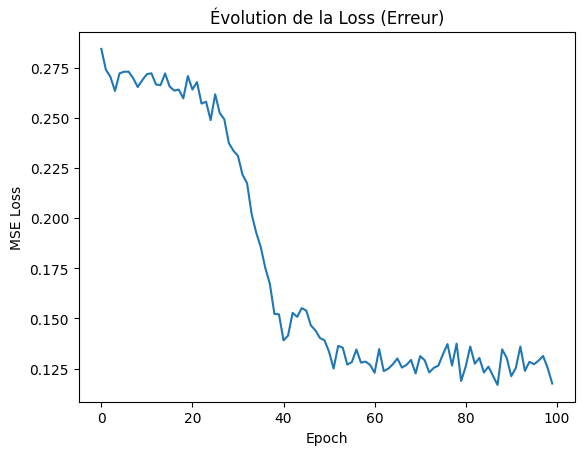

In [108]:
dataset = PenaTextAudioDataset(CONFIG['dataset_path'], CONFIG['csv_name'], CONFIG)
dataloader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = GreenTextToAudioLSTM(
    CONFIG['n_mels'], CONFIG['text_emb_dim'], CONFIG['hidden_size'], CONFIG['num_layers']
).to(CONFIG['device'])

optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
criterion = nn.MSELoss()

loss_history = []

for epoch in range(CONFIG['epochs']):
    ratio = max(0.3, 1.0 - (epoch / (CONFIG['epochs'] * 0.8)))
    print(f"Epoch {epoch+1} - Teacher Forcing Ratio: {ratio:.2f}")
    avg_loss = train_one_epoch(dataloader, model, optimizer, criterion, tokenizer, CONFIG['device'], teacher_forcing_ratio=ratio)
    loss_history.append(avg_loss)

    print(f"Epoch [{epoch+1}/{CONFIG['epochs']}] \t Loss: {avg_loss:.6f}")

    if (epoch+1) % 10 == 0:
        torch.save(model.state_dict(), f"{CONFIG['save_dir']}/model_epoch_{epoch+1}.pt")

plt.plot(loss_history)
plt.title("Évolution de la Loss (Erreur)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [109]:
import torch
import torchaudio
from IPython.display import Audio, display

model.eval()

test_prompt = "Traditional Paso Doble music for bullfighting, festive banda, pena"
txt_in = tokenizer([test_prompt], return_tensors="pt").to(CONFIG['device'])

real_spec, _ = dataset[0]
seed_audio = real_spec[:, :100]
seed = seed_audio.unsqueeze(0).to(CONFIG['device'])

gen_seq = seed.clone()
curr_in = seed

with torch.no_grad():
    for i in range(1000):
        pred = model(curr_in, txt_in['input_ids'], txt_in['attention_mask'])
        next_frame = pred[:, -1:, :]

        next_frame_perturbed = next_frame

        gen_seq = torch.cat((gen_seq, next_frame_perturbed), dim=1)
        curr_in = torch.cat((curr_in, next_frame_perturbed), dim=1)

        if curr_in.size(1) > 100:
            curr_in = curr_in[:, -100:, :]

waveform = spectrogram_to_audio(gen_seq.squeeze(0).cpu())

out_path = f"{CONFIG['save_dir']}/generated_test_noise.wav"
torchaudio.save(out_path, waveform.unsqueeze(0), CONFIG['sample_rate'])

display(Audio(out_path))

Min: 0.00
Max: 1.00
Mean: 0.83


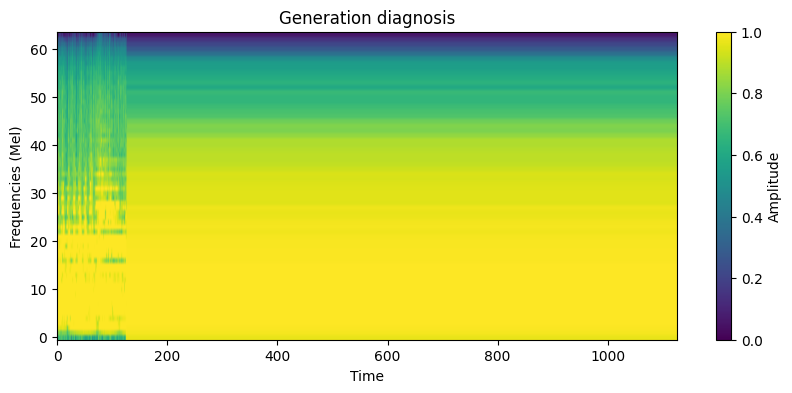

In [110]:
import matplotlib.pyplot as plt
import torch

def diagnose_generation(generated_spec):
    spec = generated_spec.squeeze().cpu().detach().numpy()

    print(f"Min: {spec.min():.2f}")
    print(f"Max: {spec.max():.2f}")
    print(f"Mean: {spec.mean():.2f}")

    plt.figure(figsize=(10, 4))
    plt.imshow(spec.T, origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='Amplitude')
    plt.title("Generation diagnosis")
    plt.xlabel("Time")
    plt.ylabel("Frequencies (Mel)")
    plt.show()

diagnose_generation(gen_seq)